# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

## Inspecting the data

any comment about data dimensionality/distribution goes here

In [1]:
import pandas as pd
import numpy as np
import os

# Suppress TensorFlow logging warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_data(path, train=True):
    df = pd.read_csv(path, encoding="ISO-8859-2")
    if train:
        data = df.sample(frac=1, random_state=42).values
        return data[:, 1:-1].astype(np.float32), data[:, -1]
    return df.iloc[:, 1:].values.astype(np.float32), df.iloc[:, 0].astype(str)

# Load datasets
X_train, labels = load_data('./train.csv')
X_test, ids = load_data('./test.csv', train=False)

# Print training set dimensions and first samples
print(f"Training set dimensions: {X_train.shape}\nFeatures count: {X_train.shape[1]}")
print("\nFirst 5 training samples:\n", pd.DataFrame(X_train).head())

# Labels distribution and missing values
print("\nLabels distribution:\n", pd.Series(labels).value_counts())
print("\nMissing values:\n", pd.read_csv('./train.csv').isnull().sum())
print("\nSummary statistics:\n", pd.read_csv('./train.csv').describe())

# Print test set dimensions
print("\nTest set dimensions:", X_test.shape)

Training set dimensions: (25500, 23)
Features count: 23

First 5 training samples:
          0    1    2    3     4    5    6    7    8    9   ...       13  \
0   70000.0  2.0  3.0  2.0  26.0  0.0  0.0  0.0  0.0  0.0  ...   8948.0   
1  320000.0  2.0  2.0  2.0  28.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...    944.0   
2   30000.0  2.0  2.0  2.0  36.0  0.0 -1.0 -1.0  0.0  0.0  ...  30452.0   
3   20000.0  2.0  3.0  1.0  35.0  0.0  0.0  2.0  2.0  0.0  ...  18621.0   
4   80000.0  1.0  2.0  2.0  32.0  1.0  2.0  0.0  0.0  0.0  ...  28242.0   

        14       15       16      17       18      19      20      21      22  
0   9006.0  10570.0  11421.0  2000.0   1200.0  1500.0  2000.0  1000.0  2000.0  
1    473.0   1747.0   1193.0   390.0    944.0   473.0  5000.0  1200.0   980.0  
2  29667.0  28596.0  29180.0   490.0  33299.0  1400.0   572.0   584.0   400.0  
3  18024.0  18434.0  19826.0  3000.0   1000.0     0.0   700.0  1700.0     0.0  
4  21400.0      0.0      0.0     7.0   1200.0  1408.0     0.0    

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

Missing values:
 ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


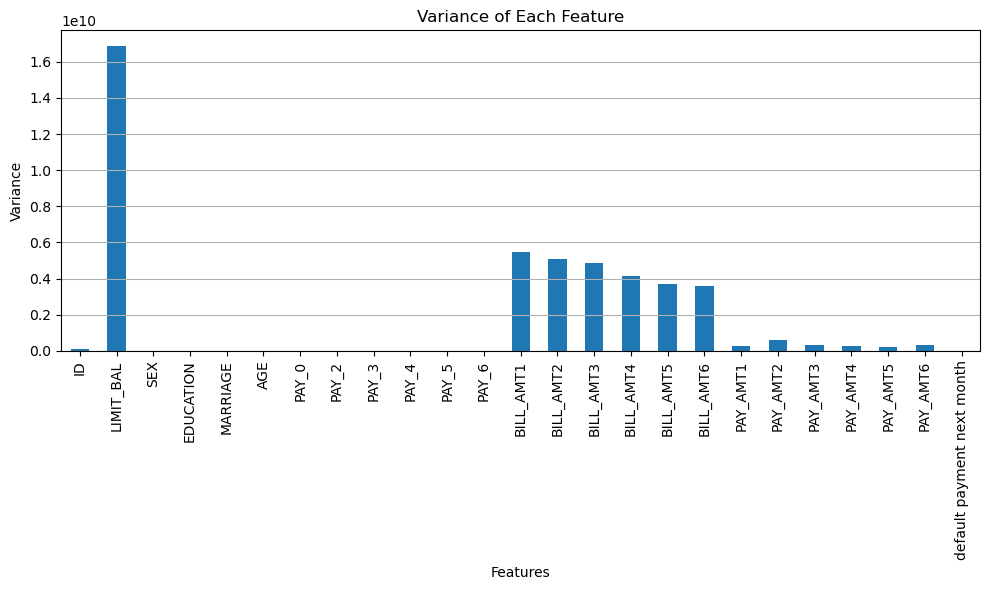

Shapes -> Train: (17850, 23), Val: (7650, 23), Test: (4500, 23), Encoded Train: (17850, 2), Encoded Val: (7650, 2)


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def preprocess_data(X, scaler=None):
    if scaler is None:
        scaler = StandardScaler().fit(X)
    return scaler.transform(X), scaler

def preprocess_labels(y, encoder=None):
    if encoder is None:
        encoder = LabelEncoder().fit(y)
    return to_categorical(encoder.transform(y)), encoder

# Load data
df_train = pd.read_csv('./train.csv')

# Separare le features e le etichette
labels_raw = df_train['default payment next month']  # Sostituisci con il nome corretto della colonna target

columns_to_drop = ["ID"]

# columns_to_drop = ["ID", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

# Creare il DataFrame delle features
X_train_raw = df_train.drop(columns=columns_to_drop + ['default payment next month'])  # Escludere la colonna target

# Check for missing values
print("Missing values:\n", df_train.isnull().sum())

# Plot variance
plt.figure(figsize=(10, 6))
df_train.var().plot(kind='bar')
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, labels_raw, 
                                                  test_size=0.3, random_state=42, stratify=labels_raw)

# Scale features and encode labels
X_train_scaled, scaler = preprocess_data(X_train)
X_val_scaled, _ = preprocess_data(X_val, scaler)
y_train_encoded, encoder = preprocess_labels(y_train)
y_val_encoded, _ = preprocess_labels(y_val, encoder)

# Preprocess test data
X_test_raw = pd.read_csv('./test.csv').drop(columns=columns_to_drop)
X_test_scaled, _ = preprocess_data(X_test_raw, scaler)

# Print shapes of datasets
print(f"Shapes -> Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}, "
      f"Encoded Train: {y_train_encoded.shape}, Encoded Val: {y_val_encoded.shape}")

## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

In [29]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Assumiamo che X_train e y_train siano già definiti
# Normalizzare i dati di input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Normalizza X_train
X_val_scaled = scaler.transform(X_val)  # Normalizza X_val con lo stesso scaler

# Step 2: Definire l'architettura della rete neurale
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    model.add(Dense(256, activation='relu', kernel_regularizer='l2'))  # Layer con più neuroni
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Dropout ridotto a 0.4

    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(32, activation='leaky_relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))  # Layer di output

    # Compilare il modello
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

# Step 3: Costruire il modello
input_shape = X_train_scaled.shape[1]  
model = build_model(input_shape)

# Step 4: Definire i parametri di addestramento
batch_size = 64
epochs = 3

# Step 5: Early stopping e learning rate scheduler per prevenire l'overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Callback personalizzato per visualizzare le metriche come una progress bar
class ProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
    
    def on_epoch_end(self, epoch, logs=None):
        # Format delle metriche
        metrics = f"Epoch {self.epoch + 1}/{self.params['epochs']} - " \
                  f"loss: {logs['loss']:.4f} - " \
                  f"val_loss: {logs['val_loss']:.4f} - " \
                  f"accuracy: {logs['accuracy']:.4f} - " \
                  f"val_accuracy: {logs['val_accuracy']:.4f}"
        print("\r" + metrics, end='')

# Step 6: Addestrare il modello
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr, ProgressBar()],
                    verbose=0) 

# Step 7: Valutare il modello sul set di validazione
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)  

print("\nRESULTS:")
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Step 8: Calcolare e stampare l'F1 Score
y_pred_prob = model.predict(X_val_scaled, verbose=0)  # Anche qui imposta verbose a 0
y_pred = (y_pred_prob > 0.5).astype(int)  

f1 = f1_score(y_val, y_pred)  
print(f"F1 Score: {f1}")

Epoch 3/3 - loss: 3.0231 - val_loss: 2.7863 - accuracy: 0.7536 - val_accuracy: 0.8094
RESULTS:
Validation Loss: 2.78629994392395, Validation Accuracy: 0.8094117641448975
F1 Score: 0.48589562764456984


## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

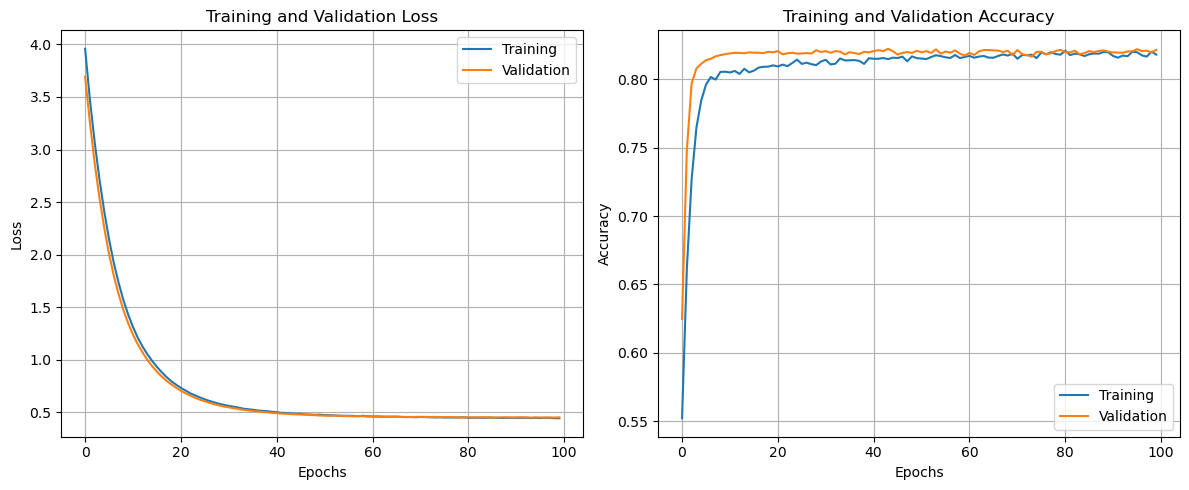

Final Training Loss: 0.4415
Final Validation Loss: 0.4497
Final Training Accuracy: 0.8181
Final Validation Accuracy: 0.8216


In [247]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over epochs.

    This function generates two subplots: one for the training and validation loss, 
    and another for the training and validation accuracy. It utilizes a helper 
    function to streamline the plotting process.

    Parameters:
    history : object
        An object containing training history data, typically returned by a 
        Keras model's fit method. It should contain 'loss', 'val_loss', 
        'accuracy', and 'val_accuracy' attributes.

    Returns:
    None
    """
    
    def plot_metric(metric, title, ylabel):
        """
        Helper function to plot a given metric.

        Parameters:
        metric : dict
            A dictionary containing 'train' and 'val' keys for training 
            and validation metrics respectively.
        title : str
            The title of the plot.
        ylabel : str
            The label for the y-axis.

        Returns:
        None
        """
        plt.plot(metric['train'], label='Training')
        plt.plot(metric['val'], label='Validation')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid()

    plt.figure(figsize=(12, 5))  # Set the figure size for better visibility

    plt.subplot(1, 2, 1)  # Create the first subplot for loss metrics
    plot_metric(
        {'train': history.history['loss'], 'val': history.history['val_loss']},
        'Training and Validation Loss',
        'Loss'
    )

    plt.subplot(1, 2, 2)  # Create the second subplot for accuracy metrics
    plot_metric(
        {'train': history.history['accuracy'], 'val': history.history['val_accuracy']},
        'Training and Validation Accuracy',
        'Accuracy'
    )

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the plots

# Example call to the plot_training_history function
plot_training_history(history)

# Extracting final metrics from the training history
final_metrics = {
    'loss': (history.history['loss'][-1], history.history['val_loss'][-1]),
    'accuracy': (history.history['accuracy'][-1], history.history['val_accuracy'][-1])
}

# Printing final metrics in a formatted manner
for metric, (train, val) in final_metrics.items():
    print(f"Final Training {metric.capitalize()}: {train:.4f}")
    print(f"Final Validation {metric.capitalize()}: {val:.4f}")

## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Step 1: Generate predictions on the validation set
y_val_pred_prob = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Confusion Matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(confusion)

# Step 3: Classification Report
class_report = classification_report(y_val, y_val_pred, target_names=["No Default", "Default"])
print("Classification Report:")
print(class_report)

# Step 4: Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[5624  321]
 [1044  661]]
Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.95      0.89      5945
     Default       0.67      0.39      0.49      1705

    accuracy                           0.82      7650
   macro avg       0.76      0.67      0.69      7650
weighted avg       0.81      0.82      0.80      7650

ROC AUC Score: 0.7825


## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [32]:
# Load the test data
X_test, test_ids = load_data(url_test, train=False)

# Preprocess the test data
X_test_scaled, _ = preprocess_data(X_test)

# Step 1: Make predictions on the test set
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Create a DataFrame for submission or further analysis
results = pd.DataFrame({
    'Default_Prediction': y_test_pred.flatten()
})

# Step 3: Save predictions to a CSV file (optional)
results.to_csv('test_predictions.csv', index=False, header=False)

# Display predictions
print("Predictions on Test Set:")
print(results.head())


Columns in the dataset: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
Predictions on Test Set:
   Default_Prediction
0                   0
1                   0
2                   0
3                   0
4                   0


# OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify you prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).

In [145]:
import numpy as np
import pandas as pd  # Importare pandas per il caricamento del CSV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  # Importa per il train/val split
from tensorflow.keras import regularizers

# Step 1: Caricare il dataframe da train.csv
df = pd.read_csv('train.csv')  # Carica il dataframe

# Assicurati che la colonna "default payment next month" contenga solo valori binari
df['default payment next month'] = df['default payment next month'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else np.nan))

# Rimuovi righe con valori NaN
df.dropna(subset=['default payment next month'], inplace=True)

# Step 1.1: Definire X_train e y_train
X = df.drop(columns=['default payment next month']).values  # Tutte le colonne tranne "default payment next month"
y = df['default payment next month'].values  # Utilizza i valori della colonna "default payment next month"

# Step 1.2: Suddividere il dataset in training e validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizzare i dati di input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Normalizza X_train
X_val_scaled = scaler.transform(X_val)  # Normalizza X_val con lo stesso scaler

# Step 2: Definire l'architettura della rete neurale con meno regularizzazione e più complessità
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    # Primo livello con He initialization, regularizzazione L2 ridotta e Batch Normalization
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())

    # Secondo livello con più neuroni
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())

    # Terzo livello con più neuroni
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())

    # Quarto livello aggiunto per aumentare la complessità
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())

    # Livello di output con attivazione sigmoid
    model.add(Dense(1, activation='sigmoid'))

    # Compilare il modello con un learning rate leggermente più alto
    optimizer = Adam(learning_rate=0.0003, clipnorm=1.0)  # Clipnorm per evitare gradienti esplosivi
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

# Step 3: Costruire il modello
input_shape = X_train_scaled.shape[1]  
model = build_model(input_shape)

# Step 4: Definire i parametri di addestramento
batch_size = 64
epochs = 50

# Step 5: Early stopping e learning rate scheduler per prevenire l'overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

model.summary()

# Step 6: Addestrare il modello
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr])

# Step 7: Valutare il modello sul set di validazione
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Step 8: Calcolare e stampare l'F1 Score
y_pred_prob = model.predict(X_val_scaled)  
y_pred = (y_pred_prob > 0.5).astype(int)  

# Modifica il calcolo dell'F1 score
f1 = f1_score(y_val, y_pred, average='macro')  
print(f"F1 Score: {f1}")

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_321 (Dense)               │ (None, 256)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_243         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_322 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_244         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_245         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_246         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,585 (201.50 KB)

 Trainable params: 50,625 (197.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6340 - loss: 0.7239 - val_accuracy: 0.8041 - val_loss: 0.4901 - learning_rate: 5.0000e-04
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7711 - loss: 0.5362 - val_accuracy: 0.8067 - val_loss: 0.4623 - learning_rate: 5.0000e-04
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8031 - loss: 0.4854 - val_accuracy: 0.8092 - val_loss: 0.4557 - learning_rate: 5.0000e-04
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8054 - loss: 0.4775 - val_accuracy: 0.8112 - val_loss: 0.4522 - learning_rate: 5.0000e-04
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8002 - loss: 0.4767 - val_accuracy: 0.8112 - val_loss: 0.4497 - learning_rate: 5.0000e-04
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8057 - loss: 0.4702 - val_accuracy: 0.8125 - val_loss: 0.4481 - learning_rate: 5.0000e-04
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy over epochs.

    Parameters
    ----------
    history: History
        Keras History object containing training metrics.
    """
    # Plotting Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Step 1: Call the plot function to visualize the training history
plot_training_history(history)

# Step 2: Analyze results
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Step 3: Initial considerations
if final_train_loss < final_val_loss:
    print("The model performs better on the training set compared to the validation set, which might indicate overfitting.")
elif final_train_loss > final_val_loss:
    print("The model performs better on the validation set compared to the training set, indicating potential underfitting.")
else:
    print("The model performs similarly on both sets, suggesting a good fit.")